In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import os
import sys
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Add the parent directory to the system path
sys.path.append(os.path.abspath('..'))

# Import preprocessing utilities
from EDA.clean_data import clean_data

# Import the LSTM module functions
from TwoLayerLSTM import (
    TwoLayerESGModel,
    ESGTimeSeriesDataset,
    train_two_layer_model,
    evaluate_two_layer_model,
    visualize_esg_results,
    analyze_esg_predictor,
    plot_dynamic_weight_change
)

In [3]:
# Define the relative path to the CSV file
file_path = os.path.join('..', 'data', 'energy_cleaned.csv')

df = pd.read_csv(file_path)

df = clean_data(df)

df.head()


Dataset shape: (850, 67)
Number of companies: 118
Year range: 2015 to 2023


,Company,Ticker,Year,BESG ESG Score,BESG Environmental Pillar Score,BESG Social Pillar Score,BESG Governance Pillar Score,ESG Disclosure Score,Environmental Disclosure Score,Social Disclosure Score,...,Country_New Zealand,Country_Norway,Country_Poland,Country_Portugal,Country_Spain,Country_Switzerland,Country_Thailand,Country_United Arab Emirates,Country_United Kingdom,Country_United States
1,ACS Actividades de Construccion y Servicios SA,ACS,2015,1.85,0.66,2.38,3.66,55.296,42.616,41.717,...,False,False,False,False,True,False,False,False,False,False
2,ACS Actividades de Construccion y Servicios SA,ACS,2016,2.17,1.13,2.37,4.05,55.497,48.354,36.578,...,False,False,False,False,True,False,False,False,False,False
3,ACS Actividades de Construccion y Servicios SA,ACS,2017,2.76,1.13,4.30,4.11,57.248,50.317,44.891,...,False,False,False,False,True,False,False,False,False,False
4,ACS Actividades de Construccion y Servicios SA,ACS,2018,2.63,1.11,4.20,3.64,62.609,52.280,59.039,...,False,False,False,False,True,False,False,False,False,False
5,ACS Actividades de Construccion y Servicios SA,ACS,2019,2.79,1.31,4.21,3.87,64.390,57.626,59.039,...,False,False,False,False,True,False,False,False,False,False


In [4]:
# Define target columns in the proper order:
# 1. Main ESG Score first
# 2. Pillar scores
# 3. Disclosure scores
target_cols = [
    'BESG ESG Score',                # Main ESG Score - the ultimate target
    'BESG Environmental Pillar Score', # Component: Environmental Pillar
    'BESG Social Pillar Score',        # Component: Social Pillar
    'BESG Governance Pillar Score',    # Component: Governance Pillar
    'ESG Disclosure Score',            # Component: Overall ESG Disclosure
    'Environmental Disclosure Score',  # Component: Environmental Disclosure
    'Social Disclosure Score',         # Component: Social Disclosure
    'Governance Disclosure Score'      # Component: Governance Disclosure
]

In [5]:
# First, verify the correlation between the components and the ESG score
component_cols = target_cols[1:]
corr_df = df[target_cols].corr()

print("\nCorrelation of component scores with ESG Score:")
print(corr_df['BESG ESG Score'].sort_values(ascending=False))


Correlation of component scores with ESG Score:
BESG ESG Score                     1.000000
BESG Environmental Pillar Score    0.918117
ESG Disclosure Score               0.801137
BESG Social Pillar Score           0.739926
Environmental Disclosure Score     0.706130
Social Disclosure Score            0.696146
Governance Disclosure Score        0.490789
BESG Governance Pillar Score       0.464822
Name: BESG ESG Score, dtype: float64


In [6]:
# Create a multiple regression to verify R² between components and ESG score
X_reg = df[component_cols]
y_reg = df['BESG ESG Score']

reg_model = LinearRegression()
reg_model.fit(X_reg, y_reg)
y_pred = reg_model.predict(X_reg)

r2 = r2_score(y_reg, y_pred)
print(f"\nR² of linear regression from components to ESG score: {r2:.6f}")

print("\nRegression coefficients:")
for component, coef in zip(component_cols, reg_model.coef_):
    print(f"{component}: {coef:.6f}")
print(f"Intercept: {reg_model.intercept_:.6f}")



R² of linear regression from components to ESG score: 0.993430

Regression coefficients:
BESG Environmental Pillar Score: 0.483065
BESG Social Pillar Score: 0.291660
BESG Governance Pillar Score: 0.237175
ESG Disclosure Score: 1.546196
Environmental Disclosure Score: -0.515209
Social Disclosure Score: -0.514080
Governance Disclosure Score: -0.515832
Intercept: -0.119616


In [ ]:
# Get all feature columns (excluding the target variables)
all_features = [col for col in target_cols if col not in 'BESG ESG Score']

# Define X and y for feature selection
X_stepwise = df[all_features].fillna(0)  # Simple imputation for missing values
y_stepwise = df['BESG ESG Score']

# Implement stepwise feature selection
def stepwise_selection(X, y, initial_features=None, threshold_in=0.01, threshold_out=0.05, verbose=True):
    """
    Perform stepwise feature selection

    Args:
        X (pd.DataFrame): Features DataFrame
        y (pd.Series): Target variable
        initial_features (list): Initial features to include (default: empty)
        threshold_in (float): p-value threshold for adding features
        threshold_out (float): p-value threshold for removing features
        verbose (bool): Whether to print progress

    Returns:
        list: Selected feature names
    """
    initial_features = [] if initial_features is None else initial_features

    # Initial list of features
    features = list(initial_features)

    # All possible features
    all_candidates = list(X.columns)

    # Iterate until no feature can be added or removed
    while True:
        # Variables to add or remove
        changed = False

        # Forward step - evaluate adding each feature
        excluded = list(set(all_candidates) - set(features))
        new_pval = pd.Series(index=excluded, dtype=float)

        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(X[features + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]

        # Select best feature to add (with lowest p-value)
        best_pval = new_pval.min()

        # If p-value is significant, add the feature
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            features.append(best_feature)
            changed = True
            if verbose:
                print(f'Added {best_feature} with p-value {best_pval}')

        # Backward step - evaluate removing each feature
        if len(features) > 0:
            model = sm.OLS(y, sm.add_constant(X[features])).fit()

            # Get p-values for all features (except constant)
            p_values = model.pvalues.iloc[1:]  # Skip the constant term

            # If any p-value is not significant, remove the worst feature
            worst_pval = p_values.max()
            if worst_pval > threshold_out:
                worst_feature = p_values.idxmax()
                features.remove(worst_feature)
                changed = True
                if verbose:
                    print(f'Dropped {worst_feature} with p-value {worst_pval}')

        # Break if no changes made in this iteration
        if not changed:
            break

    return features

# Run stepwise selection
import statsmodels.api as sm
selected_features = stepwise_selection(X_stepwise, y_stepwise,
                                      threshold_in=0.01,
                                      threshold_out=0.05,
                                      verbose=True)

print("\nFeatures selected by stepwise selection:")
for feature in selected_features:
    print(f"- {feature}")

# Evaluate model with selected features
X_selected = df[selected_features].fillna(0)
reg_model_selected = LinearRegression()
reg_model_selected.fit(X_selected, y_stepwise)
y_pred_selected = reg_model_selected.predict(X_selected)

r2_selected = r2_score(y_stepwise, y_pred_selected)
print(f"\nR² of linear regression with selected features: {r2_selected:.6f}")

# Compare with full feature set
X_all = df[all_features].fillna(0)
reg_model_all = LinearRegression()
reg_model_all.fit(X_all, y_stepwise)
y_pred_all = reg_model_all.predict(X_all)

r2_all = r2_score(y_stepwise, y_pred_all)
print(f"R² of linear regression with all features: {r2_all:.6f}")

# Optional: Calculate adjusted R-squared
def adjusted_r2(r2, n, p):
    """Calculate adjusted R-squared

    Args:
        r2 (float): R-squared value
        n (int): Number of observations
        p (int): Number of predictors

    Returns:
        float: Adjusted R-squared
    """
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

n = len(y_stepwise)
p_selected = len(selected_features)
p_all = len(all_features)

adj_r2_selected = adjusted_r2(r2_selected, n, p_selected)
adj_r2_all = adjusted_r2(r2_all, n, p_all)

print(f"Adjusted R² with selected features: {adj_r2_selected:.6f}")
print(f"Adjusted R² with all features: {adj_r2_all:.6f}")

Added BESG Environmental Pillar Score with p-value 0.0
Added BESG Social Pillar Score with p-value 1.040493198263738e-177
Added BESG Governance Pillar Score with p-value 0.0

Features selected by stepwise selection:
- BESG Environmental Pillar Score
- BESG Social Pillar Score
- BESG Governance Pillar Score

R² of linear regression with selected features: 0.993394
R² of linear regression with all features: 0.993430
Adjusted R² with selected features: 0.993371
Adjusted R² with all features: 0.993375


In [8]:
target_cols = [
    'BESG ESG Score',                # Main ESG Score - the ultimate target
    'BESG Environmental Pillar Score', # Component: Environmental Pillar
    'BESG Social Pillar Score',        # Component: Social Pillar
    'BESG Governance Pillar Score',    # Component: Governance Pillar
]

cols_to_drop = [
    'ESG Disclosure Score',            # Component: Overall ESG Disclosure
    'Environmental Disclosure Score',  # Component: Environmental Disclosure
    'Social Disclosure Score',         # Component: Social Disclosure
    'Governance Disclosure Score'     # Component: Governance Disclosure
]

In [9]:
component_cols = target_cols[1:]

# Create a multiple regression to verify R² between components and ESG score
X_reg = df[component_cols]
y_reg = df['BESG ESG Score']

reg_model = LinearRegression()
reg_model.fit(X_reg, y_reg)
y_pred = reg_model.predict(X_reg)

r2 = r2_score(y_reg, y_pred)
print(f"\nR² of linear regression from components to ESG score: {r2:.6f}")

print("\nRegression coefficients:")
for component, coef in zip(component_cols, reg_model.coef_):
    print(f"{component}: {coef:.6f}")
print(f"Intercept: {reg_model.intercept_:.6f}")



R² of linear regression from components to ESG score: 0.993394

Regression coefficients:
BESG Environmental Pillar Score: 0.483116
BESG Social Pillar Score: 0.293558
BESG Governance Pillar Score: 0.242384
Intercept: -0.079918


In [21]:
# Train the two-layer model
model, train_loader, test_loader, test_dataset, feature_names, history, device, component_cols = train_two_layer_model(
    df.drop(columns=cols_to_drop),  # Drop columns not used for training
    target_cols,
    hidden_size=256,         # Size of LSTM hidden layers
    num_layers=10,            # Number of LSTM layers
    seq_length=3,            # Number of time steps to look back
    learning_rate=0.001,     # Learning rate for optimizer
    train_size=0.8,          # Proportion of companies to use for training
    epochs=1000,             # Maximum number of training epochs
    patience=100,            # Early stopping patience
    batch_size=64,           # Batch size for training
    dropout=0.5,             # Dropout rate for LSTM layers
    initial_component_weight=0.1,
    threshold=1.0,
)

Using device: cpu
Training model...
Epoch 5/1000 | Train Loss: 20.0014 | Val Loss: 23.4864 | ESG Loss: 19.4273 | Component Loss: 25.1687 | Component Weight: 0.1000
Epoch 10/1000 | Train Loss: 17.9268 | Val Loss: 23.4213 | ESG Loss: 17.3647 | Component Loss: 22.9859 | Component Weight: 0.1000
Epoch 15/1000 | Train Loss: 15.8105 | Val Loss: 20.6763 | ESG Loss: 15.2761 | Component Loss: 20.6207 | Component Weight: 0.1000
Epoch 20/1000 | Train Loss: 13.9327 | Val Loss: 15.9392 | ESG Loss: 13.3827 | Component Loss: 18.8823 | Component Weight: 0.1000
Epoch 25/1000 | Train Loss: 11.5642 | Val Loss: 12.6175 | ESG Loss: 11.0001 | Component Loss: 16.6411 | Component Weight: 0.1000
Epoch 30/1000 | Train Loss: 9.1918 | Val Loss: 10.1195 | ESG Loss: 8.6335 | Component Loss: 14.2165 | Component Weight: 0.1000
Epoch 35/1000 | Train Loss: 6.7794 | Val Loss: 9.4732 | ESG Loss: 6.2383 | Component Loss: 11.6494 | Component Weight: 0.1000
Epoch 40/1000 | Train Loss: 4.9457 | Val Loss: 11.2116 | ESG Loss: 

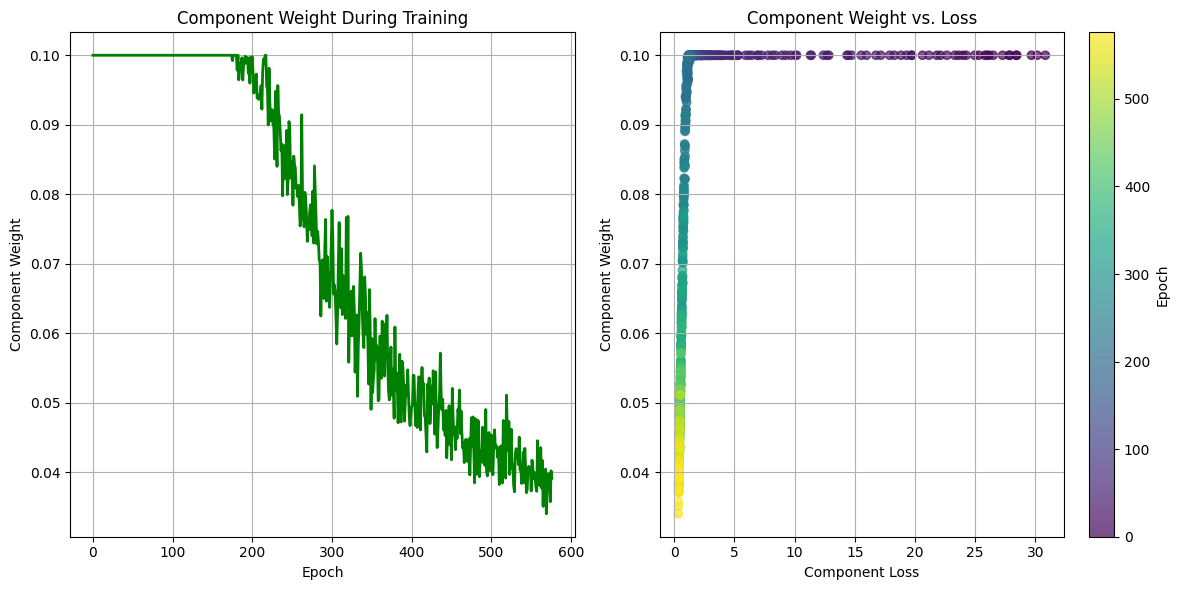

In [11]:
plot_dynamic_weight_change(history)

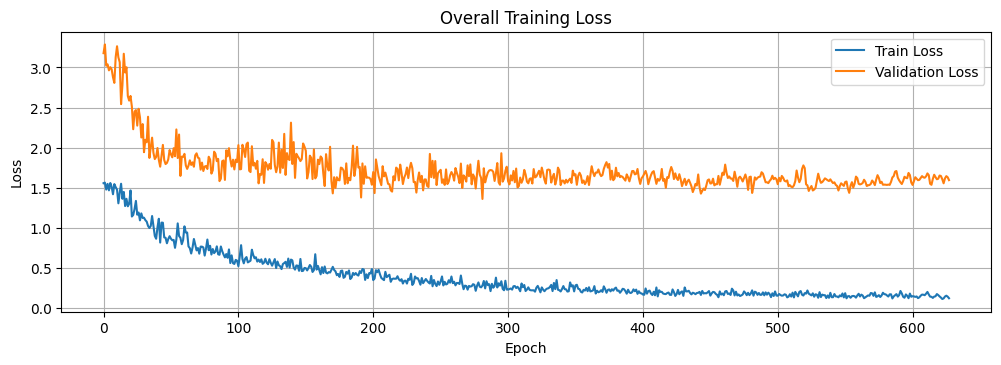

In [20]:
# Plot training history
plt.figure(figsize=(12, 8))

# Plot overall loss
plt.subplot(2, 1, 1)
plt.plot(history['train_loss'][100:], label='Train Loss')
plt.plot(history['val_loss'][100:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Overall Training Loss')
plt.legend()
plt.grid(True)

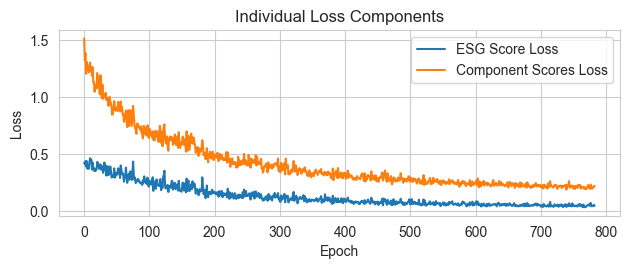

In [28]:
# Plot component losses
plt.subplot(2, 1, 2)
plt.plot(history['esg_loss'][100:], label='ESG Score Loss')
plt.plot(history['component_loss'][100:], label='Component Scores Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Individual Loss Components')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model

# Read model from .pt file
try:
	# Try loading the model directly
	best_model_state = torch.load('best_two_layer_model.pt')

	# Check if it's a state dictionary
	if isinstance(best_model_state, dict) and 'state_dict' in best_model_state:
		best_model = best_model_state['model']
	elif hasattr(best_model_state, 'state_dict'):
		best_model = best_model_state
	else:
		# Create a new model with the same architecture as the trained one
		best_model = TwoLayerESGModel(
			input_size=len(feature_names),
			hidden_size=256,
			num_layers=3,
			component_size=len(component_cols),
			dropout=0.2
		)
		# Load the state dictionary
		best_model.load_state_dict(best_model_state)
except Exception as e:
	print(f"Error loading model from file: {e}")
	# Use the model that was already trained in this notebook
	print("Using the model trained in this notebook instead.")
	best_model = model

results = evaluate_two_layer_model(best_model, test_loader, device, component_cols)

# Print ESG score metrics
print("\nESG Score Prediction Metrics:")
print(f"MSE: {results['esg']['mse']:.6f}")
print(f"RMSE: {results['esg']['rmse']:.6f}")
print(f"MAE: {results['esg']['mae']:.6f}")
print(f"R²: {results['esg']['r2']:.6f}")

# Print average component metrics
print("\nAverage Component Score Metrics:")
print(f"MSE: {results['components']['avg_mse']:.6f}")
print(f"RMSE: {results['components']['avg_rmse']:.6f}")
print(f"MAE: {results['components']['avg_mae']:.6f}")
print(f"R²: {results['components']['avg_r2']:.6f}")

Error loading model from file: Error(s) in loading state_dict for TwoLayerESGModel:
	Unexpected key(s) in state_dict: "lstm.weight_ih_l3", "lstm.weight_hh_l3", "lstm.bias_ih_l3", "lstm.bias_hh_l3", "lstm.weight_ih_l3_reverse", "lstm.weight_hh_l3_reverse", "lstm.bias_ih_l3_reverse", "lstm.bias_hh_l3_reverse", "lstm.weight_ih_l4", "lstm.weight_hh_l4", "lstm.bias_ih_l4", "lstm.bias_hh_l4", "lstm.weight_ih_l4_reverse", "lstm.weight_hh_l4_reverse", "lstm.bias_ih_l4_reverse", "lstm.bias_hh_l4_reverse". 
Using the model trained in this notebook instead.

ESG Score Prediction Metrics:
MSE: 1.412816
RMSE: 1.188619
MAE: 0.941004
R²: 0.178960

Average Component Score Metrics:
MSE: 2.064529
RMSE: 1.390485
MAE: 1.083862
R²: 0.214521


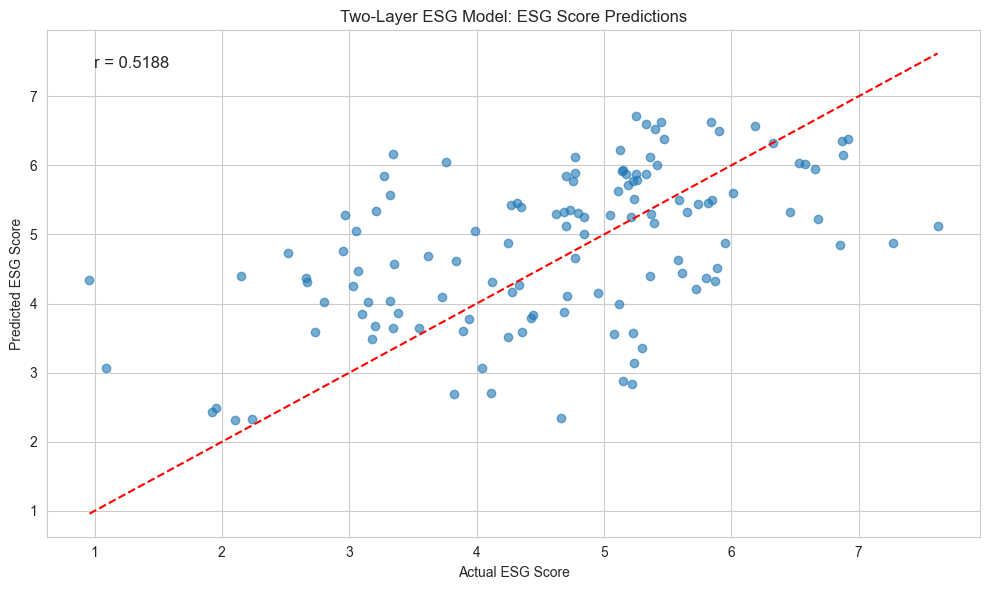

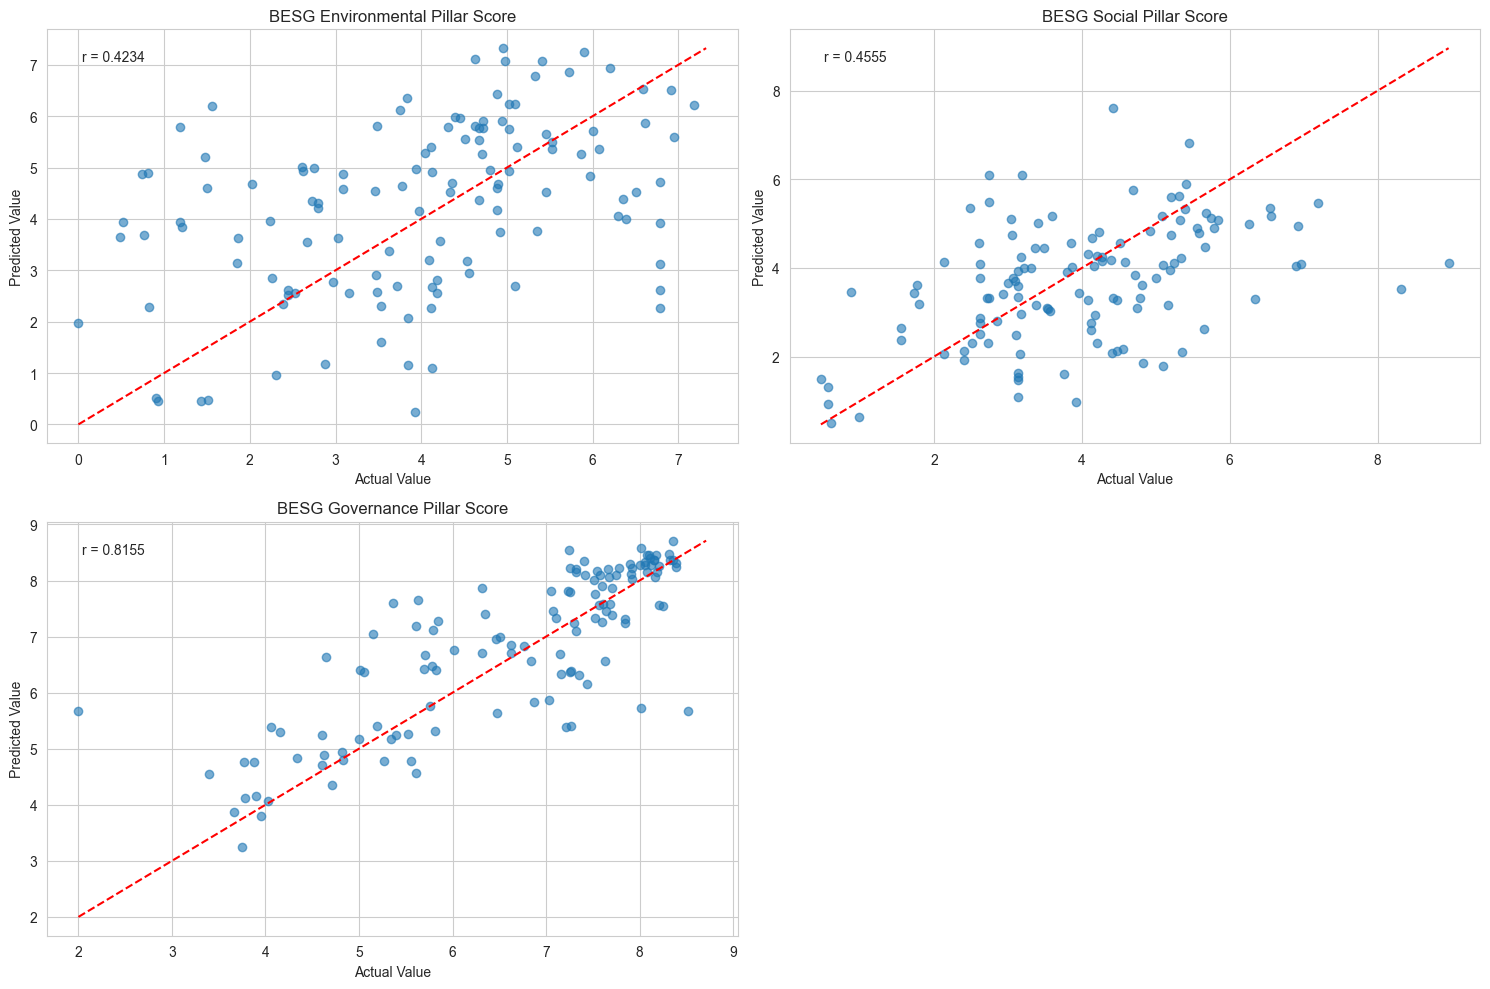


Model Performance Metrics:


,mse,rmse,mae,r2
component,,,,
BESG Environmental Pillar Score,3.430820,1.852247,1.496868,-0.156409
BESG Social Pillar Score,2.427224,1.557955,1.192990,0.007265
BESG Governance Pillar Score,0.790500,0.889101,0.636945,0.629920
ESG Score,1.485631,1.218865,0.993262,0.136644
Avg Component,2.216181,1.433101,1.108934,0.160259


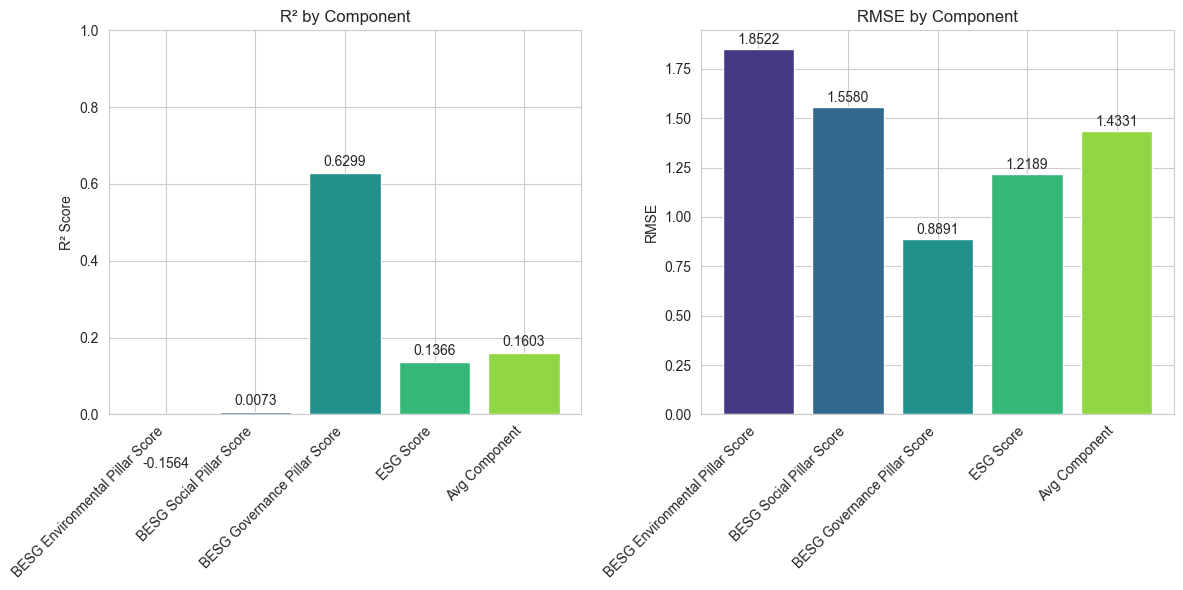

In [15]:
# Visualize results
metrics_df = visualize_esg_results(results, component_cols)

In [14]:
# Analyze the ESG predictor (second layer) weights
weights, bias = analyze_esg_predictor(model)

# Display the weights and bias
print("\nESG Predictor Weights (Second Layer):")
for i, component in enumerate(component_cols):
    print(f"{component}: {weights[0, i]:.6f}")
print(f"Bias: {bias[0]:.6f}")


ESG Predictor Weights (Second Layer):
BESG Environmental Pillar Score: 0.408878
BESG Social Pillar Score: 0.291969
BESG Governance Pillar Score: 0.199322
Bias: 0.557947


In [15]:
# Compare with the linear regression model
print("\nComparison of ESG predictor weights with linear regression:")
comparison = pd.DataFrame({
    'Component': component_cols,
    'LSTM Layer Weight': weights[0],
    'Linear Regression': reg_model.coef_
})
comparison['Difference'] = comparison['LSTM Layer Weight'] - comparison['Linear Regression']
print(comparison)

# Also compare the bias terms
print(f"\nBias - LSTM Layer: {bias[0]:.6f}, Linear Regression: {reg_model.intercept_:.6f}")
print(f"Difference: {bias[0] - reg_model.intercept_:.6f}")

# Explain the model architecture
print("\nTwo-Layer ESG Model Architecture:")
print("1. First Layer: Bidirectional LSTM with attention mechanism")
print("   - Processes sequential company data over time")
print("   - Predicts the 7 component scores (Pillar and Disclosure scores)")
print("2. Second Layer: Linear regression")
print("   - Takes the 7 component scores as input")
print("   - Predicts the final ESG score")
print("\nThe model is trained with a custom loss function that:")
print(f"- Places {(1-0.2)*100:.0f}% weight on ESG score prediction accuracy")
print(f"- Places {0.2*100:.0f}% weight on component score prediction accuracy")


Comparison of ESG predictor weights with linear regression:
                         Component  LSTM Layer Weight  Linear Regression  \
0  BESG Environmental Pillar Score           0.408878           0.483116   
1         BESG Social Pillar Score           0.291969           0.293558   
2     BESG Governance Pillar Score           0.199322           0.242384   

   Difference  
0   -0.074238  
1   -0.001589  
2   -0.043062  

Bias - LSTM Layer: 0.557947, Linear Regression: -0.079918
Difference: 0.637866

Two-Layer ESG Model Architecture:
1. First Layer: Bidirectional LSTM with attention mechanism
   - Processes sequential company data over time
   - Predicts the 7 component scores (Pillar and Disclosure scores)
2. Second Layer: Linear regression
   - Takes the 7 component scores as input
   - Predicts the final ESG score

The model is trained with a custom loss function that:
- Places 80% weight on ESG score prediction accuracy
- Places 20% weight on component score prediction accurac

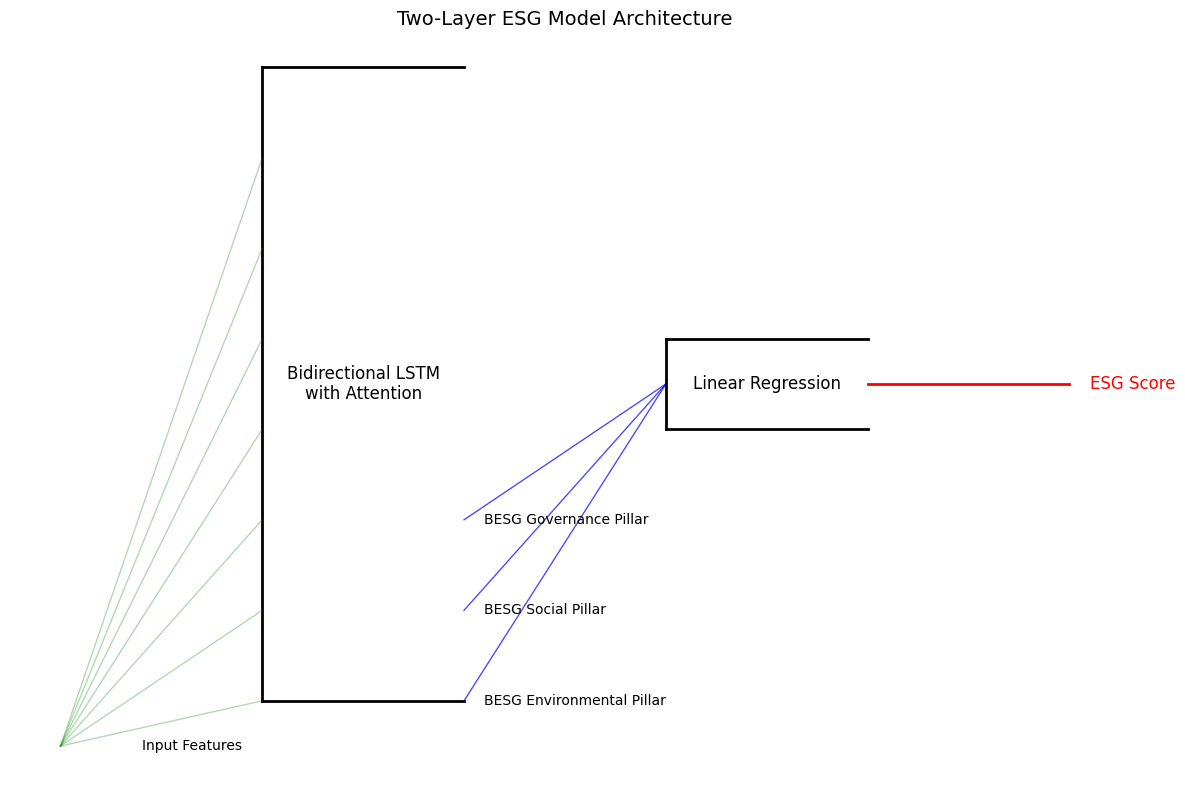

In [16]:
# Visualize the architecture
plt.figure(figsize=(12, 8))
plt.subplot(1, 1, 1)

# LSTM layer representation
plt.plot([0, 0], [0, 7], 'k-', linewidth=2)
plt.plot([0, 2], [0, 0], 'k-', linewidth=2)
plt.plot([0, 2], [7, 7], 'k-', linewidth=2)
plt.text(1, 3.5, "Bidirectional LSTM\nwith Attention", ha='center', va='center', fontsize=12)

# Component scores representation
for i, component in enumerate(component_cols):
    plt.plot([2, 4], [i, 3.5], 'b-', linewidth=1, alpha=0.7)
    plt.text(2.2, i, component.replace(" Score", ""), fontsize=10, ha='left', va='center')

# ESG predictor representation
plt.plot([4, 4], [3, 4], 'k-', linewidth=2)
plt.plot([4, 6], [3, 3], 'k-', linewidth=2)
plt.plot([4, 6], [4, 4], 'k-', linewidth=2)
plt.text(5, 3.5, "Linear Regression", ha='center', va='center', fontsize=12)

# ESG score representation
plt.plot([6, 8], [3.5, 3.5], 'r-', linewidth=2)
plt.text(8.2, 3.5, "ESG Score", fontsize=12, ha='left', va='center', color='r')

# Input features representation
plt.text(-0.2, -0.5, "Input Features", fontsize=10, ha='right', va='center')
for i in range(7):
    plt.plot([-2, 0], [-0.5, i], 'g-', linewidth=1, alpha=0.3)

plt.axis('off')
plt.title('Two-Layer ESG Model Architecture', fontsize=14)
plt.tight_layout()
plt.savefig('model_architecture.png', dpi=300, bbox_inches='tight')
plt.show()


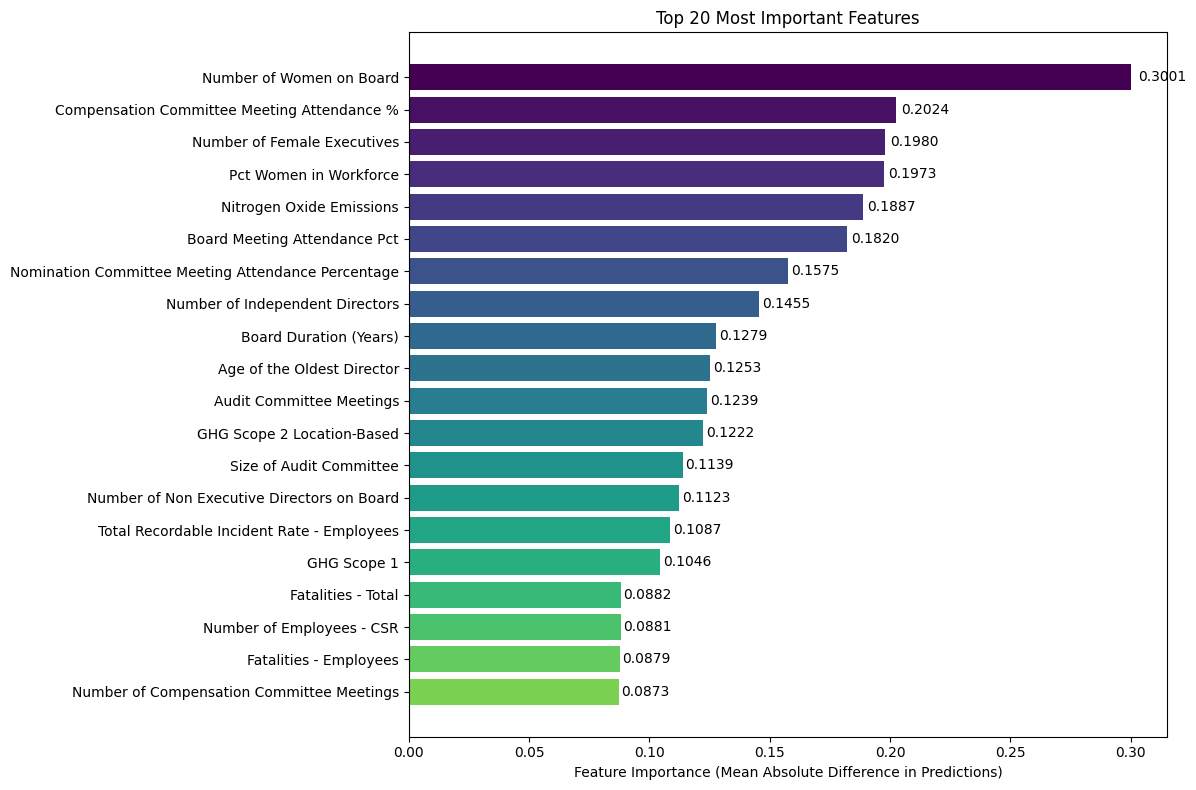

In [17]:
# Analyze the feature importance based on gradient-based approaches
def analyze_feature_importance(model, test_dataset, feature_names, device, n_samples=50):
    """
    Analyze feature importance using input perturbation
    """
    model.to(device)
    model.eval()

    # Get a subset of test data
    from torch.utils.data import DataLoader, Subset

    # Create a subset of the test dataset
    subset_indices = np.random.choice(len(test_dataset), min(n_samples, len(test_dataset)), replace=False)
    subset = Subset(test_dataset, subset_indices)
    subset_loader = DataLoader(subset, batch_size=1, shuffle=False)

    # Calculate baseline predictions
    baseline_preds = []

    with torch.no_grad():
        for batch in subset_loader:
            features = batch['features'].to(device)
            _, _, esg_pred = model(features)
            baseline_preds.append(esg_pred.cpu().numpy())

    baseline_preds = np.concatenate(baseline_preds)

    # Calculate importance for each feature
    importances = {}

    for feat_idx, feature_name in enumerate(feature_names):
        # Reset loader
        subset_loader = DataLoader(subset, batch_size=1, shuffle=False)

        # Permute the feature and calculate new predictions
        permuted_preds = []

        with torch.no_grad():
            for batch in subset_loader:
                features = batch['features'].clone().to(device)

                # Permute this feature across the sequence
                for seq_idx in range(features.size(1)):
                    # Zero out this feature (setting it to the mean, which is 0 after standardization)
                    features[0, seq_idx, feat_idx] = 0

                _, _, esg_pred = model(features)
                permuted_preds.append(esg_pred.cpu().numpy())

        permuted_preds = np.concatenate(permuted_preds)

        # Importance is the mean absolute difference in predictions
        importance = np.mean(np.abs(baseline_preds - permuted_preds))
        importances[feature_name] = importance

    # Sort by importance
    importances = {k: v for k, v in sorted(importances.items(), key=lambda item: item[1], reverse=True)}

    return importances

# Get feature importance
feature_importances = analyze_feature_importance(best_model, test_dataset, feature_names, device, n_samples=50)

# Plot feature importance
plt.figure(figsize=(12, 8))

# Get top 20 features
top_n = 20
top_features = list(feature_importances.keys())[:top_n]
top_values = [feature_importances[f] for f in top_features]

# Create plot
bars = plt.barh(range(len(top_features)), top_values, color=plt.cm.viridis(np.linspace(0, 0.8, len(top_features))))

# Add feature names
plt.yticks(range(len(top_features)), top_features)

# Add values to bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width * 1.01, i, f'{width:.4f}', ha='left', va='center')

plt.xlabel('Feature Importance (Mean Absolute Difference in Predictions)')
plt.title('Top 20 Most Important Features')
plt.gca().invert_yaxis()  # Display the most important at the top
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
# Print top 10 most important features
print("\nTop 10 most important features:")
for i, (feature, importance) in enumerate(list(feature_importances.items())[:10]):
    print(f"{i+1}. {feature}: {importance:.6f}")



Top 10 most important features:
1. Number of Women on Board: 0.300123
2. Compensation Committee Meeting Attendance %: 0.202371
3. Number of Female Executives: 0.197958
4. Pct Women in Workforce: 0.197290
5. Nitrogen Oxide Emissions: 0.188749
6. Board Meeting Attendance Pct: 0.181965
7. Nomination Committee Meeting Attendance Percentage: 0.157452
8. Number of Independent Directors: 0.145468
9. Board Duration (Years): 0.127876
10. Age of the Oldest Director: 0.125345
